In [1]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import pandas as pd
import glob
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, AvgPool2D, Reshape , Conv2D, MaxPooling2D, UpSampling2D ,Conv2DTranspose, Add, Activation, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os

In [2]:
def load_images_from_directory(directory):
    images = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, filename)
                image = load_img(img_path, target_size=(128,128))  # Resize image
                image_array = img_to_array(image)  # Convert to NumPy array
                image_array /= 255.0  # Normalize pixel values to [0, 1]
                images.append(image_array)
    images = np.array(images)
    return images

In [3]:
# Load images for x and y
x = []
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainA"))
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainA"))
x.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainA"))
x.extend(load_images_from_directory("/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/input"))

y = []
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainB"))
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainB"))
y.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainB"))
y.extend(load_images_from_directory("/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT"))

# Convert lists to numpy arrays
x_array = np.array(x)
y_array = np.array(y)

# Check the shapes of the arrays
print(f"x_array shape: {x_array.shape}")
print(f"y_array shape: {y_array.shape}")

x_array shape: (16292, 128, 128, 3)
y_array shape: (16292, 128, 128, 3)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in color
image = cv2.imread('/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainB/n01496331_10040.jpg')

# Convert the image to YUV color space
yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

# Apply histogram equalization only on the Y channel (luminance channel)
yuv_image[:, :, 0] = cv2.equalizeHist(yuv_image[:, :, 0])

# Convert the image back to BGR
equalized_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

# Display the original and equalized images
plt.figure(figsize=(10,5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Equalized Image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
plt.title('Equalized Image')
plt.axis('off')

plt.show()


In [4]:
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), padding="same"):
    shortcut = x
    # First convolutional layer
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)  # Batch normalization
    x = Activation("relu")(x)    # ReLU activation

    # Second convolutional layer
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)    # ReLU activation
    
    # Add the shortcut (skip connection) to the output of the second convolution
    x = Add()([x, shortcut])
    x = Activation("relu")(x)    # ReLU activation for the final output
    return x

def ResNet(input_shape=(128, 128, 3), num_blocks=5):
    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolution layer
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    # x = AvgPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) #(224,224,64)
    
    # Residual blocks
    for _ in range(num_blocks):
        x = residual_block(x, 64)

    # Upsampling block
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # x = Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding='same')(x)
        
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    
    # Output layer for enhanced image
    enhanced_image = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    # Create model
    model = Model(inputs, enhanced_image)
    
    return model

# Instantiate the model
# resnet_model = ResNet(num_blocks=20)  #10 Adjust number of residual blocks as needed
# resnet_model.summary()


In [4]:
def ssim_m(y_true, y_pred):
    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(ssim_value)

def psnr_m(y_true, y_pred):
    psnr_value = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(psnr_value)

def color_loss(y_true, y_pred):
    # Convert images to RGB histograms
    hist_true = tf.reduce_mean(y_true, axis=[0, 1])
    hist_pred = tf.reduce_mean(y_pred, axis=[0, 1])

    # Calculate the difference between histograms (in RGB space)
    return tf.reduce_mean(tf.abs(hist_true - hist_pred))

In [5]:
data_sets = [("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainA","/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainB"),
             ("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainA","/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainB"),
             ("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_dark/trainA","/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_dark/trainB"),
             ("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainA","/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainB")]

In [ ]:
for x_path,y_path in data_sets:
    # Reading the Data
    x = load_images_from_directory(x_path)
    y = load_images_from_directory(y_path)
    x_array = np.array(x)
    y_array = np.array(y)
    print(f"x_array shape: {x_array.shape}")
    print(f"y_array shape: {y_array.shape}")
    
    # Splitting the Data
    X_train, X_test, y_train, y_test = train_test_split(x_array, y_array, test_size=0.4, random_state=42, shuffle=True)
    X_val , X_test , y_val , y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

    # Training the Model
    hist = resnet_model.fit(X_train , y_train , batch_size=16 , epochs=20 , validation_data=(X_val , y_val))

    # Vsiualising the out put
    mse = MeanSquaredError()
    
    test_decoded_imgs = resnet_model.predict(X_test)
    val_decoded_imgs = resnet_model.predict(X_val)
    train_decoded_imgs = resnet_model.predict(X_train)
    
    test_mse = mse(y_test, test_decoded_imgs)
    val_mse = mse(y_val, val_decoded_imgs)
    train_mse = mse(y_train, train_decoded_imgs)
    
    print(f"train mse : {train_mse}")
    print(f"val mse : {val_mse}")
    print(f"test mse : {test_mse}")
    
    n = 10 
    plt.figure(figsize=(20, 10))    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(X_test[i+100].astype("float32"))
        plt.title("Original")
        plt.axis("off")
    
        ax = plt.subplot(3, n, i + n + 1)
        plt.imshow(y_test[i+100].astype("float32"))
        plt.title("Should Be")
        plt.axis("off")
        
        ax = plt.subplot(3, n, i + 2 * n + 1)
        plt.imshow(test_decoded_imgs[i+100])
        plt.title("Reconstructed")
        plt.axis("off")
    
    plt.show()

    # Visualising the train vs validation loss
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # Visualising the train vs validation accuracy
    plt.plot(hist.history['accuracy'], label='Training acc')
    plt.plot(hist.history['val_accuracy'], label='Validation acc')
    plt.legend()
    plt.show()
    print("-----"*20)
    # del x,y,x_array,y_array,X_train,X_test,y_train,y_test,hist,decoded_imgs

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x_array, y_array, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

In [6]:
del x_array,y_array

In [7]:
# Initialize New Model
resnet_model = ResNet(num_blocks=10)

# Compiling the Model
resnet_model.compile(optimizer=Adam(learning_rate=0.00005), loss="mse", metrics=["accuracy","mae"])

# MODEL

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [8]:
hist = resnet_model.fit(X_train , y_train , batch_size=16 , epochs=50 , validation_data=(X_val,y_val))#, callbacks=[early_stopping]

Epoch 1/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 146s 203ms/step - accuracy: 0.4669 - loss: 0.0483 - mae: 0.1507 - val_accuracy: 0.6077 - val_loss: 0.0150 - val_mae: 0.0960
Epoch 2/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 108s 177ms/step - accuracy: 0.5958 - loss: 0.0122 - mae: 0.0830 - val_accuracy: 0.5920 - val_loss: 0.0100 - val_mae: 0.0749
Epoch 3/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 108s 177ms/step - accuracy: 0.6148 - loss: 0.0106 - mae: 0.0772 - val_accuracy: 0.6074 - val_loss: 0.0091 - val_mae: 0.0711
Epoch 4/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 108s 177ms/step - accuracy: 0.6286 - loss: 0.0097 - mae: 0.0741 - val_accuracy: 0.6339 - val_loss: 0.0088 - val_mae: 0.0705
Epoch 5/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 108s 177ms/step - accuracy: 0.6350 - loss: 0.0093 - mae: 0.0727 - val_accuracy: 0.6543 - val_loss: 0.0085 - val_mae: 0.0688
Epoch 6/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 108s 177ms/step - accuracy: 0.6451 - loss: 0.0092 - mae: 0.0719 - val_accuracy: 0.6735 - val_loss: 0.0080 - val_mae: 0.0666
Epoch 7/50
611/6

102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step


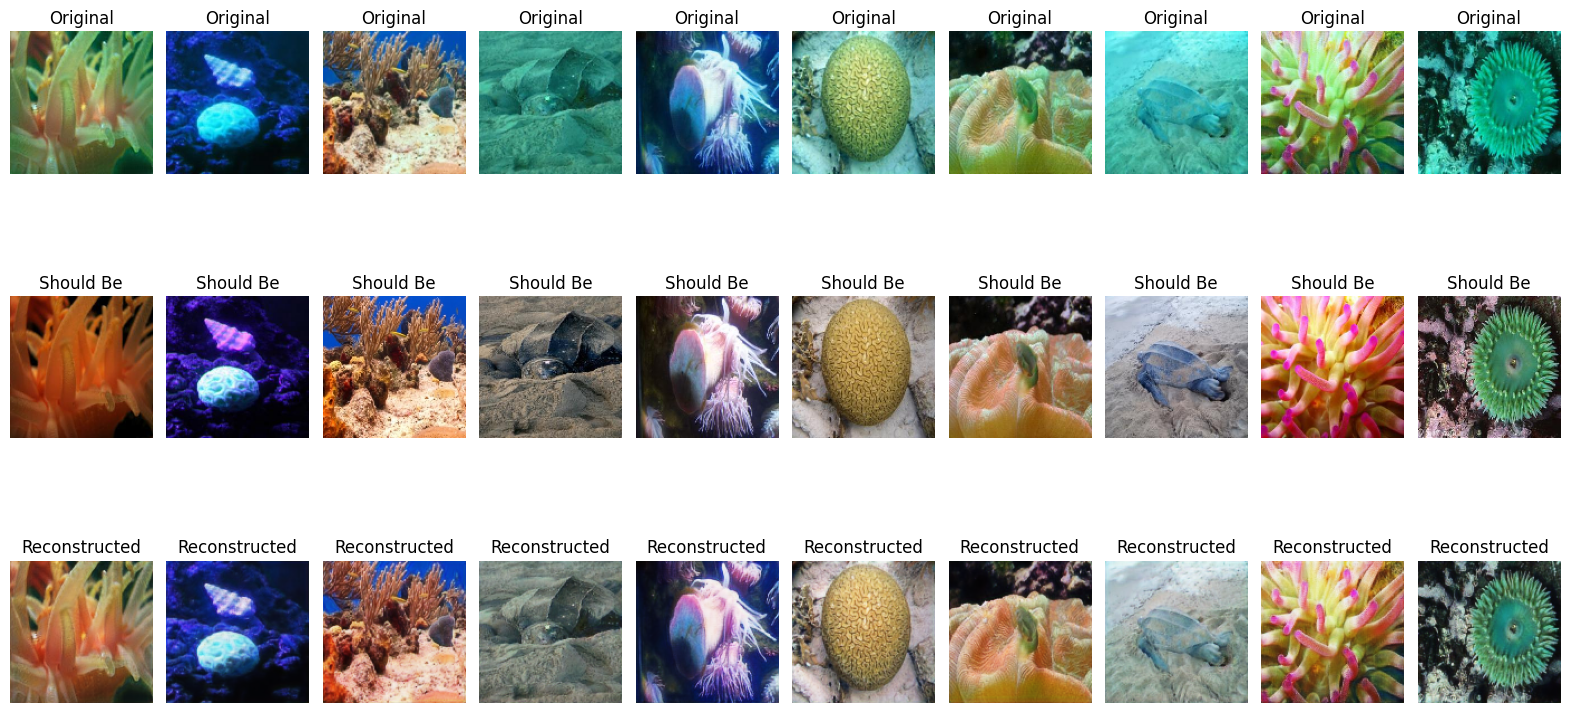

In [9]:
# Generate predictions from the model for visualization (e.g., on the validation set)
decoded_imgs = resnet_model.predict(X_test)

# Set the number of images you want to display
n = 10  # Adjust as needed

# Set a larger figsize to make room for bigger images
plt.figure(figsize=(20, 10))  # Adjust the overall size as needed

# Adjust spacing between images
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(n):
    # Display the original poor-quality image (from val_x)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i+100].astype("float32"))
    plt.title("Original")
    plt.axis("off")

    # Display the ground truth enhanced image (from val_y)
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(y_test[i+100].astype("float32"))
    plt.title("Should Be")
    plt.axis("off")
    
    # Display the reconstructed (enhanced) image (from model predictions)
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(decoded_imgs[i+100])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

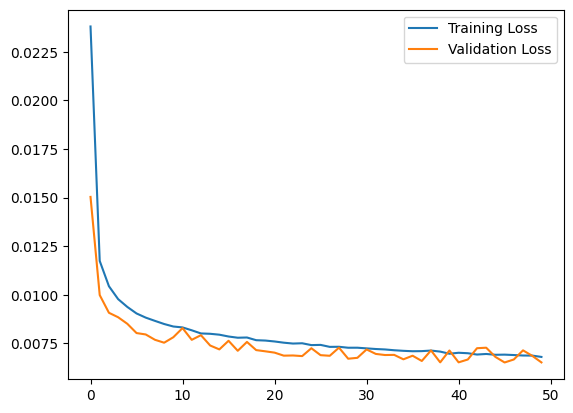

In [10]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

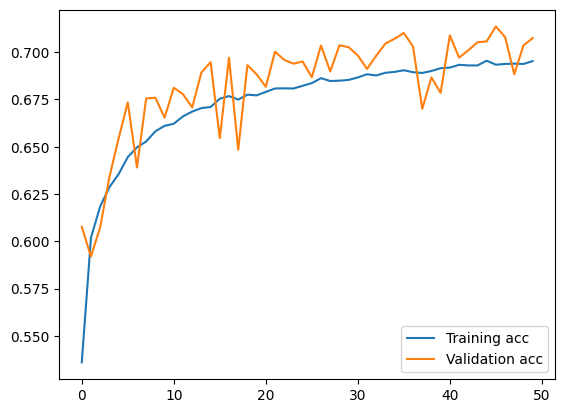

In [11]:
plt.plot(hist.history['accuracy'], label='Training acc')
plt.plot(hist.history['val_accuracy'], label='Validation acc')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the original image
image_path = '/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainA/n01496331_10373.jpg'
img = load_img(image_path, target_size=(128, 128))  # Resize to match model input size
img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Load and preprocess the ground truth enhanced image
image_pathb = '/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainB/n01496331_10373.jpg'
imgb = load_img(image_pathb, target_size=(128, 128))  # Resize to match model input size
img_arrayb = img_to_array(imgb) / 255.0  # Normalize to [0, 1]
img_arrayb = np.expand_dims(img_arrayb, axis=0)  # Add batch dimension

# Generate predictions from the model
decoded_imgs = resnet_model.predict(img_array)

# Prepare for visualization
plt.figure(figsize=(20, 10))  # Set a large figure size
n = 1  # Number of images to display (adjust if needed)

# Original Image
plt.subplot(3, n, 1)
plt.imshow(img_array[0])  # Remove batch dimension
plt.title("Original")
plt.axis("off")

# Ground Truth Enhanced Image
plt.subplot(3, n, 1 + n)
plt.imshow(img_arrayb[0])  # Remove batch dimension
plt.title("Should Be")
plt.axis("off")

# Reconstructed (Enhanced) Image
plt.subplot(3, n, 1 + 2 * n)
plt.imshow(decoded_imgs[0])  # Remove batch dimension
plt.title("Reconstructed")
plt.axis("off")

plt.tight_layout()
plt.show()


In [12]:
mse = MeanSquaredError()
    
val_decoded_imgs = resnet_model.predict(X_val)
train_decoded_imgs = resnet_model.predict(X_train)

test_mse = mse(y_test, decoded_imgs)
val_mse = mse(y_val, val_decoded_imgs)
train_mse = mse(y_train, train_decoded_imgs)

print(f"train mse : {train_mse}")
print(f"val mse : {val_mse}")
print(f"test mse : {test_mse}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step
train mse : 0.006702823098748922
val mse : 0.006518286652863026
test mse : 0.0070311338640749454


In [20]:
resnet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_46[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_47[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_48[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_60[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_61       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 128, 128,  │          0 │ activation_61[0]… │
│                     │ 64)               │            │ conv2d_48[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_62       │ (None, 128, 128,  │          0 │ add_20[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_62[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_63[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_52[0][0] 

 Total params: 4,749,355 (18.12 MB)

 Trainable params: 1,581,411 (6.03 MB)

 Non-trainable params: 5,120 (20.00 KB)

 Optimizer params: 3,162,824 (12.07 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step


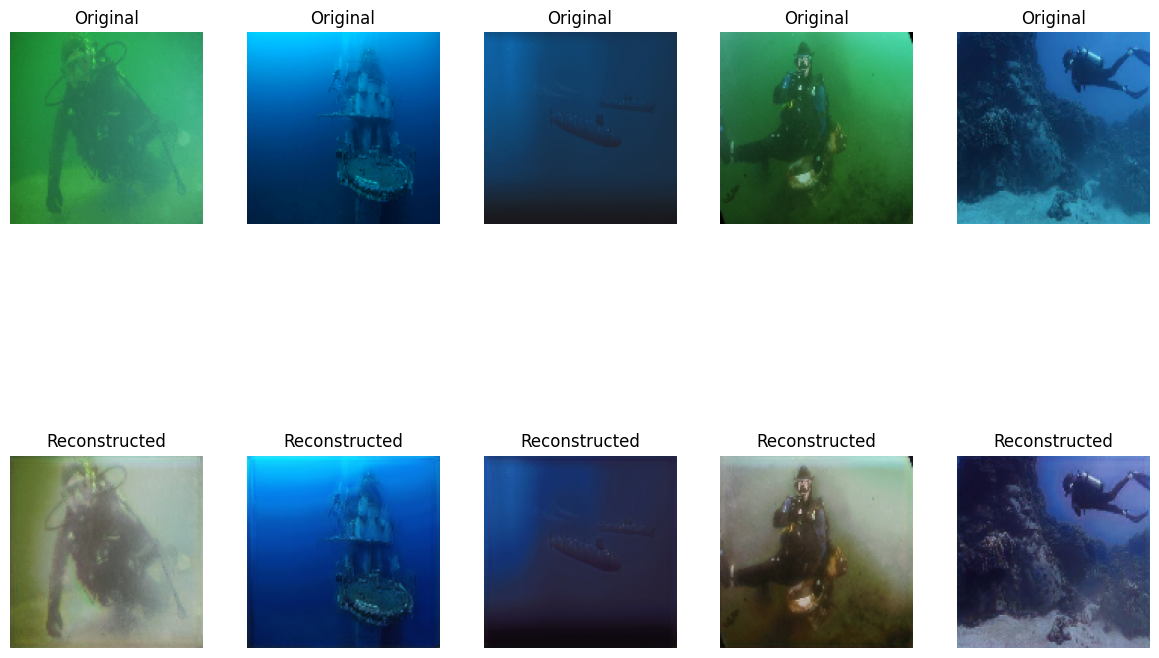

In [13]:
test = load_images_from_directory("/kaggle/input/test-data/test images")
test_imgs = resnet_model.predict(test)

n = 5 # Adjust as needed

# Set a larger figsize to make room for bigger images
plt.figure(figsize=(15, 8))  # Adjust the overall size as needed

# Adjust spacing between images
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(n):
    # Display the original poor-quality image (from val_x)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test[i].astype("float32"))
    plt.title("Original")
    plt.axis("off")

    # Display the reconstructed (enhanced) image (from model predictions)
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(test_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

174/174 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step


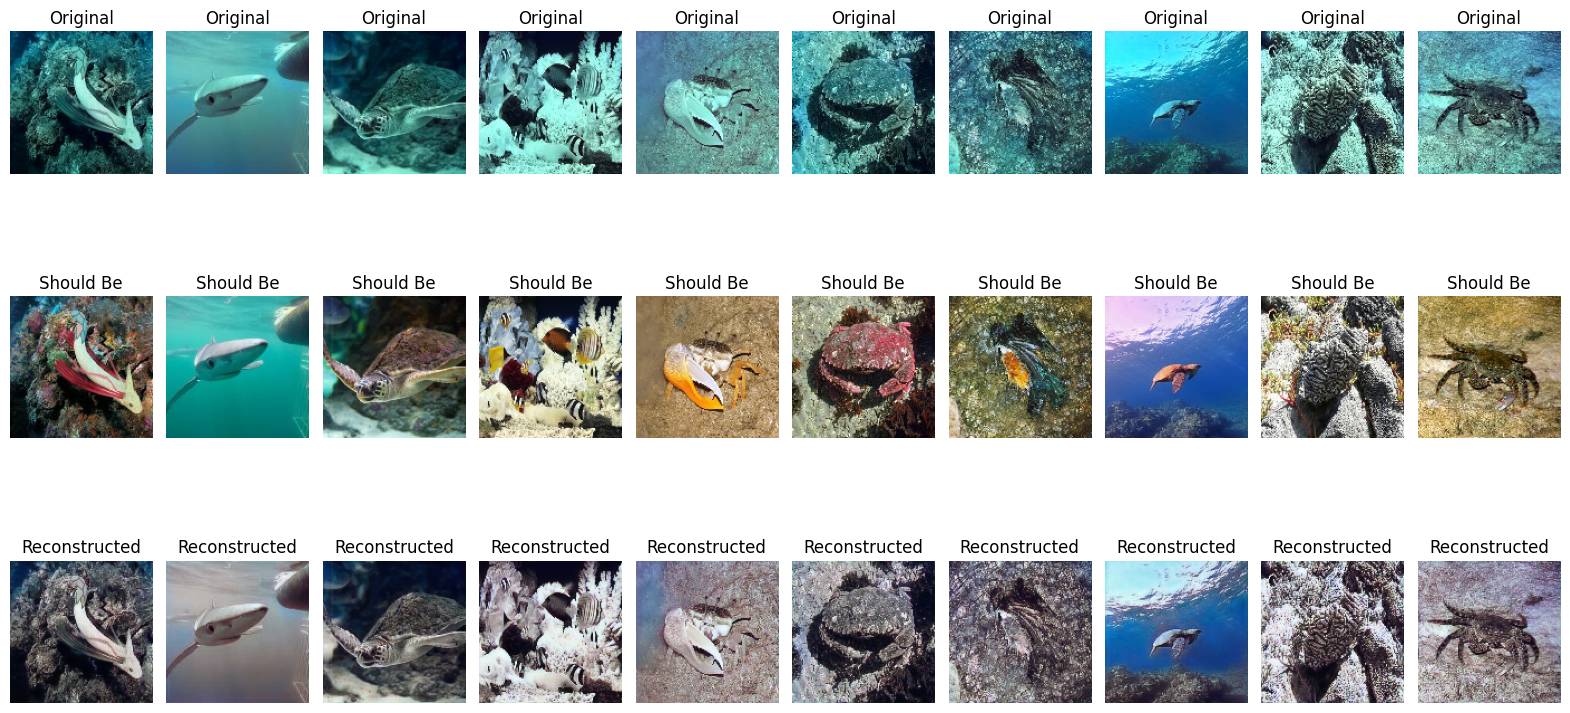

In [14]:
# Generate predictions from the model for visualization (e.g., on the validation set)
x = load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_dark/trainA")
y = load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_dark/trainB")

decoded_imgs = resnet_model.predict(x)

# Set the number of images you want to display
n = 10  # Adjust as needed

# Set a larger figsize to make room for bigger images
plt.figure(figsize=(20, 10))  # Adjust the overall size as needed

# Adjust spacing between images
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(n):
    # Display the original poor-quality image (from val_x)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i+100].astype("float32"))
    plt.title("Original")
    plt.axis("off")

    # Display the ground truth enhanced image (from val_y)
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(y[i+100].astype("float32"))
    plt.title("Should Be")
    plt.axis("off")
    
    # Display the reconstructed (enhanced) image (from model predictions)
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(decoded_imgs[i+100])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

In [16]:
resnet_model.save('UWEI_ResNet_model.h5') 

In [ ]:
selected_layers = [
    'encoder_c1_2', 'encoder_c2_2', 'encoder_c3_2',  # Encoder
    'bottleneck_c4_1',                              # Bottleneck
    'decoder_c5_2', 'decoder_c6_2', 'decoder_c7_2'  # Decoder
]

def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Adding this batch dimension ensures compatibility with the model's input expectations.
    return img_array

def visualize_feature_maps(model, image, layer_names):
    for layer_name in layer_names:
        intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        intermediate_output = intermediate_layer_model.predict(image)

        # Plot the feature maps
        num_filters = intermediate_output.shape[-1]
        plt.figure(figsize=(15, 15))
        for i in range(min(num_filters, 16)):  # Show only the first 16 feature maps 
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f"Feature maps from layer: {layer_name}", fontsize=16)
        plt.show()

image_path = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainA/imf1000.jpg"
image = preprocess_image(image_path)

visualize_feature_maps(model, image, selected_layers)